In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-23 20:00:00   278.65   278.75  278.50    278.50     3590.0
2022-02-23 19:58:00   278.65   278.65  278.65    278.65      718.0


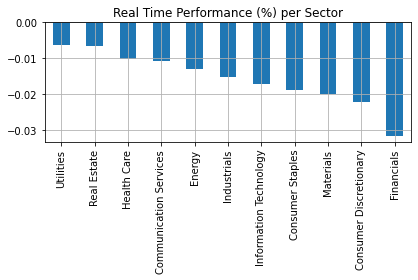

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

122.0700


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
135     DGRO
136     TD6C
137     TDG0
138    PTTRX
139      NaN
Name: Ticker, Length: 140, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
15-Feb - UP (43.6000)
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb - UP (203.5800)
16-Mar
04-Feb - UP (64.9900)
17-Feb - UP (55.6500)
27-Jan - UP (319.1700)
09-Feb - UP (8.8500)
14-Mar
09-Mar
17-Feb - UP (78.4600)
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
22-Feb - DN (124.0600)
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb - UP (80.9100)
17-Feb - DN (182.4200)
09-Feb - UP (205.9100)
09-Feb - UP (152.1600)
28-Feb
23-Feb
16-Feb - DN (9.7000)
16-Feb - DN (746.8500)
26-Jan - UP (228.2200)
15-Feb - DN (89.0600)
23-Feb
28-Feb
23-Feb
08-Feb - UP (8.5800)
22-Feb - DN (61.4600)
15-Feb - UP (61.9700)
15-Feb - UP (11.8800)
28-Feb
08-Feb - UP (364.9400)
03-Feb - UP (138.1800)
08-Feb - UP (37.2700)
10-Feb - DN (51.3400)
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb - DN (12.7600)
21-Mar
08-Mar
02-Mar
23-Feb
10-Feb - UP (629.8000)
23-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
17-Feb

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTALCURRENTASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [36]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FIRST QUARTER", "SECOND QUARTER", "THIRD QUARTER", "FOURTH QUARTER", "FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if (str(x) != "%" and str(x) != "%)") else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [37]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [89]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          


FINAL REPORT
            METRIC FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $162 - $167           

  FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                          97 - 103%         
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
           METRIC MARGIN FOURTH QUARTER FISCAL 2021 NON-GAAP GUIDANCE
6  OPERATING LOSS                                                (30 
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                              METRIC  \
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

  AMOUNT (MILLIONS) FOURTH QUARTER FISCAL 2021 GAAP GUIDANCE  
9                                                283          

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC FULL-YEAR FISCAL 2021 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $538 - $543      

  FULL-YEAR FISCAL 2021 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                         113 - 115%    
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2021 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            68%
7           OPERATING LOSS                                          (40%)
9  ADJUSTED FREE CASH FLOW                                          (18%)
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2021 GAAP GUIDANCE  
12                                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                 CASH FLOW FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                      NON-CASH OPERATING LEASE COSTS   
8                AMORTIZATION OF DEFERRED COMMISSIONS   
9   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
10  NET AMORTIZATION (ACCRETION) OF PREMIUMS (DISC...   
12                                              OTHER   
13  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
14                                ACCOUNTS RECEIVABLE   
15                               DEFERRED COMMISSIONS   
16                  PREPAID EXPENSES AND OTHER ASSETS   
17                                   ACCOUNTS PAYABLE   
18             ACC

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-36-17859192296b>", line 241, in getOneTable
    report[

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-36-17859192296b>", line 241, in getOneTable
    report[

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
1

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [98]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Quote for stock ENB on earning date 15-Feb - UP (43.6000) already generated
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Quote for stock KNSL on earning date 17-Feb - UP (203.5800) already generated
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Quote for stock APPN on earning date 17-Feb - UP (55.6500) already generated
Quote for stock TEAM on earning date 27-Jan - UP (319.1700) already generated
Quote for stock CGC on earning date 09-Feb - UP (8.8500) already gener

Update Stock ETSY with quote 24-Feb - UP (148.9400)
Earning report for stock VIR on date 2022-02-24 exists
Earning released for stock VIR AH
Get price diff for stock VIR from date 2022-02-24 and date 2022-02-25
Update Stock VIR with quote 24-Feb - DN (27.8300)
Quote for stock CMG on earning date 08-Feb - UP (1608.7400) already generated
Quote for stock ACB on earning date 10-Feb - DN (4.4900) already generated
Quote for stock JMIA on earning date 23-Feb - DN (7.5200) already generated
Earning report for stock BYND on date 2022-02-24 exists
Earning released for stock BYND AH
Get price diff for stock BYND from date 2022-02-24 and date 2022-02-25
Update Stock BYND with quote 24-Feb - DN (44.4900)
Quote for stock SNAP on earning date 03-Feb - UP (38.9100) already generated
Quote for stock UBER on earning date 09-Feb - DN (37.7500) already generated
Quote for stock ROKU on earning date 17-Feb - DN (112.4600) already generated
Quote for stock AAPL on earning date 27-Jan - UP (170.3300) alrea

In [45]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [97]:
stocks = get_earningDates(d, "YT")
print(stocks, "\n", len(stocks))

[] 
 0


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [49]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [50]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [51]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [52]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [53]:
import json
org = "CRWD"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/CRWD/profile?p=CRWD
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-transactions?p=CRWD
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/insider-roster?p=CRWD
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/CRWD/holders?p=CRWD
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 1.46%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 72.06%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 73.13%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 1394
https://finance.yahoo.com/quote/CRWD/analysis?p=CRWD
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 1/30/2021 1 1 0.13
Table Number 2
FOUND
2 4/29/2021 1 2 0.1
Table Number 2
FOUND
3 7/30/2021 1 3 0.11
Table Number 2
FOUND
4 10/30/2021 1 4 0.17
Table Number 2
FOUND
1 1/30/2021 0 1 0.08
Table Number 2
FOUND
2 4/29/2021 0 2 0.06
Tab

In [80]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/0001713683/000171368322000025/zs-01312022_991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

11


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [54]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [55]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [56]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [57]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [58]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [59]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [60]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [61]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [62]:
def isBold(tag, ctext):
    listag = ["ul", "li"]
    if((tag.name == "b" and tag.parent.name not in listag) or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [63]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tags), ctag.name, ctag.text, tags)
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.name == "u"):
                continue
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [64]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [65]:
def isPadLeft(item):
    if(item.name == "ul" or item.name == "li"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [66]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [67]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    listag = ["ul", "li"]
    if not txt:
        if(item.name in listag):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", " ")
    ctext = ctext.replace("     ", " ")
    ctext = ctext.replace("    ", " ")
    ctext = ctext.replace("   ", " ")
    ctext = ctext.replace("  ", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name not in listag and item.parent.name not in listag):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [68]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [69]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle+" .")
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk]+" .")
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata+" .")
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr+" .")
    f.write("\n")
    return possibleTblTitle

In [93]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            eyr = eyr + emonth
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    hc = False #Header continue to next row
    dollarCol = list()
    f.write("\n")
    f.write(tblStr+" .")
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            hc = False
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    if "MARGIN" in newcol.upper() and "%" not in content:
                        content = content + "%"
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite + " .")
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
                hc = True
            else:
                if hc:
                    header = header + " " + met
                else:
                    header = met
        elif(met == "TOTAL"):
            header = None
        else:
            hc = False
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr+" .")
    f.write("\n")

In [71]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br", "li"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul" and len(tag.findChildren("li", recursive=True)) == 0):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "li" and len(tag.findChildren("li", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [72]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2020-12-02"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [86]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
source = getPgSource(url)

In [87]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC  \
7                    PRODUCT GROSS PROFIT   
12                         OPERATING LOSS   
13  NET CASH USED IN OPERATING ACTIVITIES   
14                         FREE CASH FLOW   
15                ADJUSTED FREE CASH FLOW   

   AMOUNT (MILLIONS) THIRD QUARTER FISCAL 2021 GAAP RESULTS  \
7                                               $96.7         
12                                           ($169.5)         
13                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC FULL-YEAR FISCAL 2021 GAAP GUIDANCE AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                        $538 - $543      

  FULL-YEAR FISCAL 2021 GAAP GUIDANCE YEAR/YEAR GROWTH  
3                                         113 - 115%    
{0: [1, 2], 3: [4, 5, 6, 7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                    METRIC MARGIN FULL-YEAR FISCAL 2021 NON-GAAP GUIDANCE
6     PRODUCT GROSS PROFIT                                            68%
7           OPERATING LOSS                                          (40%)
9  ADJUSTED FREE CASH FLOW                                          (18%)
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
                                               METRIC  \
12  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...   

   AMOUNT (MILLIONS) FULL-YEAR FISCAL 2021 GAAP GUIDANCE  
12                                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-36-17859192296b>", line 241, in

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                 TOTAL GROSS PROFIT   
1

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                            PRODUCT GROSS

In [88]:
allTables

{'TOTAL': 11,
 'PARSESUCCESS': [0, 1, 2, 3, 4, 5, 8, 9, 10],
 'PARSEFAIL': [6, 7],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null,"12":null,"13":null,"14":null,"15":null,"16":null,"17":null},{"0":null,"1":null,"2":null,"3":"Third Quarter Fiscal 2021 GAAP Results","4":"Third Quarter Fiscal 2021 GAAP Results","5":"Third Quarter Fiscal 2021 GAAP Results","6":"Third Quarter Fiscal 2021 GAAP Results","7":"Third Quarter Fiscal 2021 GAAP Results","8":"Third Quarter Fiscal 2021 GAAP Results","9":null,"10":null,"11":null,"12":"Third Quarter Fiscal 2021 Non-GAAP Results(1)","13":"Third Quarter Fiscal 2021 Non-GAAP Results(1)","14":"Third Quarter Fiscal 2021 Non-GAAP Results(1)","15":"Third Quarter Fiscal 2021 Non-GAAP Results(1)","16":"Third Quarter Fiscal 2021 Non-GAAP Results(1)","17":"Third Quarter Fiscal 2021 Non-GAAP Results(1)"},{"0":null,"1":null,"2":null,"3":"Amount (millions)","4":"Amount (millions)","5":

In [94]:
csym = "SNOW"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/ZS_2022-02-24_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
testOne8KEdgarRpt(url, csym, None, source, allTables)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/SNOW'
NOPAD*** Document.


SC*** Snowflake Reports Financial Results for the Third Quarter of Fiscal 2021.

NOPAD*** SAN MATEO, Calif. - December 2, 2020 - Snowflake (NYSE: SNOW), provider of the Data Cloud, today announced financial results for its third quarter of fiscal 2021, ended October 31, 2020.

NOPAD*** Total revenue for the quarter was $159.6 million, representing 119% year-over-year growth. Product revenue was $148.5 million, representing 115% year-over-year growth. Remaining performance obligations were $927.9 million, representing 240% year-over-year growth. Net revenue retention rate was 162% as of October 31, 2020. The company now has 3,554 total customers and 65 customers with trailing 12-month product revenue greater than $1 million. See the section titled “Key Business Metrics” for definitions of product revenue, remaining performance obligations, net revenue retention rate, to

In [99]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [100]:
csym = "SNOW"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/SNOW'
1640147
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001628280-20-013752-index.html
EARNING REPORT ALREADY EXISTS FOR URL https://www.sec.gov/Archives/edgar/data/1640147/0001628280-20-013752-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000020-index.html
EARNING REPORT ALREADY EXISTS FOR URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000020-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000028-index.html
EARNING REPORT ALREADY EXISTS FOR URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-20-000028-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000021-index.html
EARNING REPORT ALREADY EXISTS FOR URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-000021-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1640147/0001640147-21-00010

In [101]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [102]:
csym = "SNOW"
storeEdgarRpt(csym)

1640147
TRYING TO WRITE TEXT DATA FOR SNOW, report type 10-Q, date filed 2020-12-03
TRYING TO WRITE RISKS DATA FOR SNOW, report type 10-Q, date filed 2020-12-03
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND OPERATIONS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO TAX, LEGAL, AND REGULATORY ENVIRONMENT
RISK HEADER RISKS RELATED TO THE OWNERSHIP OF CLASS A COMMON STOCK
RISKS COUNT 50
TRYING TO WRITE TABLES DATA FOR SNOW, report type 10-Q, date filed 2020-12-03
NUMBER OF TABLES 52

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                          

11           1012720               NaN  
HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC OCTOBER 31, 2020  \
3                       STOCKHOLDERS EQUITY (DEFICIT)              nan   
4   PREFERRED STOCK; $. PAR VALUE PER SHARE; ,, AN...              nan   
5   CLASS A COMMON STOCK; $. PAR VALUE PER SHARE; ...                4   
6   CLASS B COMMON STOCK; $. PAR VALUE PER SHARE; ...               24   
7                          ADDITIONAL PAID-IN CAPITAL          6007898   
8              ACCUMULATED OTHER COMPREHENSIVE INCOME              375   
9                                 ACCUMULATED DEFICIT        (1040486)   
10                TOTAL STOCKHOLDERS EQUITY (DEFICIT)          4967815   
11  TOTAL LIABILITIES, REDEEMABLE CONVERTIBLE PREF...         $5712889   

   JANUARY 31, 2020  
3               nan  
4               nan  
5               nan  
6                 6  
7            155340  
8             

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6  CHANGE IN UNREALIZED GAINS ON INVESTMENTS, NET...   
7                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                           $(168889)                            $(88057)   
5                                 nan                                 nan   
6                               (771)                                 170   
7                           $(169660)                            $(87887)   

  NINE MONTHS ENDED OCTOBER 31, 2020 NINE MONTHS ENDED OCTOBER 31, 2019  
4                          $(340167)                          $(265281)  
5                                nan                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
4                                       BALANCEJULY,    
5   CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   
6   ISSUANCE OF COMMON STOCK UPON INITIAL PUBLIC O...   
8   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
9                   EXERCISE OF COMMON STOCK WARRANTS   
10  VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
11                  VESTING OF RESTRICTED STOCK UNITS   
12                           STOCK-BASED COMPENSATION   
13                           OTHER COMPREHENSIVE LOSS   
14                                           NET LOSS   
15                                   BALANCEOCTOBER,    

   THREE MONTHS ENDED OCTOBER 31, 2020 REDEEMABLE CONVERTIBLE PREFERRED ST

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
20                                      BALANCEJULY,    
21  ISSUANCE OF SERIES F REDEEMABLE CONVERTIBLE PR...   
22  ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
23        REPURCHASE OF EARLY EXERCISED STOCK OPTIONS   
24           VESTING OF EARLY EXERCISED STOCK OPTIONS   
27                           STOCK-BASED COMPENSATION   
28                         OTHER COMPREHENSIVE INCOME   
29                                           NET LOSS   
30                                   BALANCEOCTOBER,    

   THREE MONTHS ENDED OCTOBER 31, 2019 REDEEMABLE CONVERTIBLE PREFERRED STOCK SHARES  \
20                                          169159160                                  
21          

HEADERSSSSSSSSS ['0:2', '16:18']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
4                                    BALANCEJANUARY,    
5   ISSUANCE OF SERIES G- AND SERIES G- REDEEMABLE...   
6   CONVERSION OF REDEEMABLE CONVERTIBLE PREFERRED...   
7   ISSUANCE OF COMMON STOCK UPON INITIAL PUBLIC O...   
9   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
10                  EXERCISE OF COMMON STOCK WARRANTS   
11  REPURCHASE OF EARLY EXERCISED STOCK OPTIONS AN...   
12  VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
13                  VESTING OF RESTRICTED STOCK UNITS   
14                           STOCK-BASED COMPENSATION   
15                         OTHER COMPREHENSIVE INCOME   
16                                        

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
22                                   BALANCEJANUARY,    
23  ISSUANCE OF SERIES F REDEEMABLE CONVERTIBLE PR...   
24  ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
25  REPURCHASE OF EARLY EXERCISED STOCK OPTIONS AN...   
26  VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
27                ISSUANCE OF RESTRICTED COMMON STOCK   
28  ISSUANCE OF COMMON STOCK IN CONNECTION WITH AN...   
29                           STOCK-BASED COMPENSATION   
30                         OTHER COMPREHENSIVE INCOME   
31                                           NET LOSS   
32                                   BALANCEOCTOBER,    

   NINE MONTHS ENDED OCTOBER 31, 2019 REDEEMABLE CONVERTIBLE PREFERRED STO

20                            NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4   NET INCREASE IN CASH, CASH EQUIVALENTS, AND RE...   
5   CASH, CASH EQUIVALENTS, AND RESTRICTED CASHBEG...   
6   CASH, CASH EQUIVALENTS, AND RESTRICTED CASHEND...   
7   SUPPLEMENTAL DISCLOSURES OF CASH FLOW INFORMATION   
8                          CASH PAID FOR INCOME TAXES   
9   SUPPLEMENTAL DISCLOSURES OF NON-CASH INVESTING...   
11  PROPERTY AND EQUIPMENT INCLUDED IN ACCOUNTS PA...   
14  VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
15   DEFERRED PURCHASE CONSIDERATION FOR ACQUISITIONS   
16  EQUITY CONSIDERATION IN CONNECTION WITH AN ACQ...   
17  RECONCILIATION OF CASH, CASH EQUIVALENTS AND R...   
18                          CASH AND CASH EQUIVALENTS   
19  RESTRICTED CASH  INCLUDED IN OTHER ASSETS AND ...   
20   TOTAL CASH, CASH EQUIVALENTS AND RESTRICTED CASH   

   NINE MONTHS ENDED OC

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32]}

FINAL REPORT
       METRIC REVENUE THREE MONTHS ENDED OCTOBER 31, 2020  \
4  CUSTOMER A                                           *   

  REVENUE THREE MONTHS ENDED OCTOBER 31, 2019  \
4                                           *   

  REVENUE NINE MONTHS ENDED OCTOBER 31, 2020  \
4                                          *   

  REVENUE NINE MONTHS ENDED OCTOBER 31, 2019  \
4                                        12%   

  ACCOUNTS RECEIVABLE, NET OCTOBER 31, 2020  \
4                                         *   

  ACCOUNTS RECEIVABLE, NET JANUARY 31 2020  
4                                        *  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                        0   \
0                                      NaN   
1                                      NaN   
2                   


FINAL REPORT
                                    METRIC OCTOBER 31, 2020 AMORTIZEDCOST  \
4                         CASH EQUIVALENTS                            nan   
5    U.S. GOVERNMENT AND AGENCY SECURITIES                       $3778216   
6                       MONEY MARKET FUNDS                          54422   
9                   TOTAL CASH EQUIVALENTS                        3832638   
10                             INVESTMENTS                            nan   
13   U.S. GOVERNMENT AND AGENCY SECURITIES                         982899   
14               CORPORATE NOTES AND BONDS                         111751   
16                 CERTIFICATES OF DEPOSIT                          45285   
17                        COMMERCIAL PAPER                          20837   
18                 ASSET-BACKED SECURITIES                            246   
19                       TOTAL INVESTMENTS                        1161018   
20  TOTAL CASH EQUIVALENTS AND INVESTMENTS                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                       Cash equivalents:   
4   U.S. government and agency securities   
5                      Money market funds   
6                        Commercial paper   
7                 Short-term investments:   
8              U.S. government securities   
9               Corporate notes and bonds   
10                       Commercial paper   
11                Certificates of deposit   
12                Asset-backed securities   
13                 Long-term investments:   
14  U.S. government and agency securities   
15              Corporate notes and bonds   
16                Certificates of deposit   
17                Asset-backed securities   
18                                  

{1: [2]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                0                               1  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3  Balance as of January 31, 2020  Balance as of January 31, 2020   
4                        Addition                        Addition   
5  Balance as of October 31, 2020  Balance as of October 31, 2020   

                                2                3                4  \
0                             NaN              NaN              NaN   
1                             NaN  Carrying Amount  Carrying Amount   
2                             NaN              NaN              NaN   
3  Balance as of January 31, 2020                $             7049   
4                        Addition             1400     

FINAL REPORT
                                   METRIC OCTOBER 31, 2020 JANUARY 31, 2020
3  REDEEMABLE CONVERTIBLE PREFERRED STOCK              nan        169921272
4                   COMMON STOCK WARRANTS              nan            32336
5                   EQUITY INCENTIVE PLAN              nan              nan
6                     OPTIONS OUTSTANDING         69634367         80903200
7                        RSUS OUTSTANDING          7616097              nan
8      SHARES AVAILABLE FOR FUTURE GRANTS              nan           412401
{1: [2, 2, 4, 5, 6, 7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                            Balance—January 31, 2020   
4                                   Shares aut

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}

FINAL REPORT
                       METRIC NAN UNVESTED BALANCE—JANUARY 31, 2020
6                      VESTED                                   nan
8     UNVESTED BALANCEAPRIL,           Unvested BalanceApril30 2020
10                     VESTED                                   nan
12     UNVESTED BALANCEJULY,            Unvested BalanceJuly31 2020
14                     VESTED                                   nan
16  UNVESTED BALANCEOCTOBER,         Unvested BalanceOctober31 2020

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Unvested Balance—January 31, 2020  Unvested Balance—January 31, 2020

{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 13], 15: [16, 17], 18: [19, 19]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED OCTOBER 31, 2020  \
4  EXPECTED TERM (IN YEARS)                                 5.9   
5       EXPECTED VOLATILITY                               38.4%   
6   RISK-FREE INTEREST RATE                                0.4%   
7   EXPECTED DIVIDEND YIELD                                nan%   

  THREE MONTHS ENDED OCTOBER 31, 2019 NINE MONTHS ENDED OCTOBER 31, 2020  \
4                                 6.1                                6.0   
5                               36.9%                              37.2%   
6                                1.4%                               1.0%   
7                                nan%                               nan%   

  NINE MONTHS ENDED OCTOBER 31, 2019  
4                                6.0  
5                              37.0%  
6                               2.0%  
7                       

FINAL REPORT
                                               METRIC  \
4                                     COST OF REVENUE   
5                                 SALES AND MARKETING   
6                            RESEARCH AND DEVELOPMENT   
7                          GENERAL AND ADMINISTRATIVE   
8   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
9                CAPITALIZED STOCK-BASED COMPENSATION   
10                     TOTAL STOCK-BASED COMPENSATION   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                               $13226                                $832   
5                                39481                                4802   
6                                39368                                4411   
7                                27066                               12913   
8                               119141                               22958   
9                                  284                        

FINAL REPORT
                                    METRIC OCTOBER 31, 2020 OCTOBER 31, 2019
4   REDEEMABLE CONVERTIBLE PREFERRED STOCK              nan        169921272
5                            STOCK OPTIONS         69634367         79268167
6                    COMMON STOCK WARRANTS              nan            32336
7             SHARES SUBJECT TO REPURCHASE          1171124          4034938
8                                     RSUS          7616097              nan
9                                     ESPP            85922              nan
10                                   TOTAL         78507510        253256713

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
              0              1              2   \
0            NaN            NaN            NaN   
1            NaN            NaN            NaN   
2            NaN            NaN            NaN   
3            NaN            NaN            NaN   
4  United States  United States  United States   
5       Other

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED OCTOBER 31, 2020  \
4  PRODUCT REVENUE (IN MILLIONS)                              $148.5   

  THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED APRIL 30, 2020  \
4                           $125.2                            $101.8   

  THREE MONTHS ENDED JANUARY 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  
4                               $82.4                               $69.2  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3    Remaining performance obligations (in millions)   
4                                    Total customer

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED OCTOBER 31, 2020  \
4                      REVENUE                             $159624   
5              COST OF REVENUE                               66681   
6                 GROSS PROFIT                               92943   
7           OPERATING EXPENSES                                 nan   
8          SALES AND MARKETING                              134727   
9     RESEARCH AND DEVELOPMENT                               74138   
10  GENERAL AND ADMINISTRATIVE                               53532   
11    TOTAL OPERATING EXPENSES                              262397   
12              OPERATING LOSS                            (169454)   
13             INTEREST INCOME                                1517   
14          OTHER EXPENSE, NET                               (519)   
15    LOSS BEFORE INCOME TAXES                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                        METRIC THREE MONTHS ENDED OCTOBER 31, 2020  \
4                      REVENUE                                100%   
5              COST OF REVENUE                                  42   
6                 GROSS PROFIT                                  58   
7           OPERATING EXPENSES                                 nan   
8          SALES AND MARKETING                                  84   
9     RESEARCH AND DEVELOPMENT                                  46   
10  GENERAL AND ADMINISTRATIVE                                  34   
11    TOTAL OPERATING EXPENSES                                 164   
12              OPERATING LOSS                               (106)   
13             INTEREST INCOME                                 nan   
14          OTHER EXPENSE, NET                                 nan   
15    LOSS BEFORE INCOME TAXES                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                             METRIC  \
5                   COST OF REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8             TOTAL COST OF REVENUE   
9               GROSS PROFIT (LOSS)   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12               TOTAL GROSS PROFIT   
13                     GROSS MARGIN   
14                          PRODUCT   
15  PROFESSIONAL SERVICES AND OTHER   
16               TOTAL GROSS MARGIN   
17        HEADCOUNT (AT PERIOD END)   
18                          PRODUCT   
19  PROFESSIONAL SERVICES AND OTHER   
20                  TOTAL HEADCOUNT   

   THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                                 nan           
6                                              $51816           
7         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                      METRIC  \
5   RESEARCH AND DEVELOPMENT   
6      PERCENTAGE OF REVENUE   
7  HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                             $74138           
6                                                46%           
7                                                440           

  THREE MONTHS ENDED OCTOBER 31, 2019 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                             $27669                 168%   
6                                                38%                  nan   
7                                                298                  nan   

  NINE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                            $143949          
6                                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
            METRIC THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5  INTEREST INCOME                                              $1517           

  THREE MONTHS ENDED OCTOBER 31, 2019 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                              $2491                  (39   

  NINE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS)  \
5                                              $5654          

  NINE MONTHS ENDED OCTOBER 31, 2019 (DOLLARS IN THOUSANDS) NAN % CHANGE***6  
5                                              $9252                     (39  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                        

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC FILING DATE 9/18/2020
3       .              9/8/2020
4       .              9/8/2020
5       .              9/8/2020
6       .              9/8/2020
7       .              9/8/2020
8       .              9/8/2020
9       .             8/24/2020
10      .             8/24/2020
11      .             8/24/2020
12      .             8/24/2020
13      .              9/8/2020
14      .              9/8/2020
15      .                   nan
16      .                   nan
17      .                   nan
18      .                   nan
19   .INS                   nan
20   .SCH                   nan
21   .CAL                   nan
22   .DEF                   nan
23   .LAB                   nan
24   .PRE                   nan
25                          nan

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                 0               1               2               3  \
0   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
5          CONSOLIDATED STATEMENTS OF OPERATIONS DATA   
6                                             REVENUE   
7                                     COST OF REVENUE   
8                                        GROSS PROFIT   
9                                  OPERATING EXPENSES   
10                                SALES AND MARKETING   
11                           RESEARCH AND DEVELOPMENT   
12                         GENERAL AND ADMINISTRATIVE   
13                           TOTAL OPERATING EXPENSES   
14                                     OPERATING LOSS   
15                                    INTEREST INCOME   
16                                 OTHER EXPENSE, NET   
17                           LOSS BEFORE INCOME TAXES   
18                         PROVISION FOR INCOME TAXES   
19                                           NET LOSS   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
5                     CONSOLIDATED BALANCE SHEET DATA   
6   CASH, CASH EQUIVALENTS, AND SHORT-TERM AND LON...   
7                                        TOTAL ASSETS   
8                                     WORKING CAPITAL   
9              REDEEMABLE CONVERTIBLE PREFERRED STOCK   
10                         ADDITIONAL PAID-IN CAPITAL   
11                                ACCUMULATED DEFICIT   
12                TOTAL STOCKHOLDERS EQUITY (DEFICIT)   

   AS OF JANUARY 31, 2021 (IN THOUSANDS)  \
5                                    nan   
6                               $5073339   
7                                5921739   
8                                3511388   
9                                    nan   
10                               6175425   
11                             (1239421)   
12                               4936471   



FINAL REPORT
                                              METRIC JANUARY 31, 2021 $  \
4                                    TOTAL CUSTOMERS               4139   
5                         NET REVENUE RETENTION RATE                168   
6  CUSTOMERS WITH TRAILING -MONTH PRODUCT REVENUE...                 77   

  JANUARY 31, 2021 1332.8 JANUARY 31, 2020 $ JANUARY 31, 2020 426.3  \
4                    4139               2392                   2392   
5                    168%                169                   169%   
6                      77                 41                     41   

  JANUARY 31, 2019 $ JANUARY 31, 2019 128.0  
4                948                    948  
5                180                   180%  
6                 14                     14  

FOR TABLE 11

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  11
                            0                           1   \
0                          NaN                         NaN   
1                          NaN     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                        METRIC FISCAL YEAR ENDED JANUARY 31, 2021  \
4                      REVENUE                               100%   
5              COST OF REVENUE                                 41   
6                 GROSS PROFIT                                 59   
7           OPERATING EXPENSES                                nan   
8          SALES AND MARKETING                                 81   
9     RESEARCH AND DEVELOPMENT                                 40   
10  GENERAL AND ADMINISTRATIVE                                 30   
11    TOTAL OPERATING EXPENSES                                151   
12              OPERATING LOSS                               (92)   
13             INTEREST INCOME                                  1   
14          OTHER EXPENSE, NET                                nan   
15    LOSS BEFORE INCOME TAXES                               (91)   
16  PROVISION 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                             METRIC  \
5                   COST OF REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8             TOTAL COST OF REVENUE   
9               GROSS PROFIT (LOSS)   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12               TOTAL GROSS PROFIT   
13                     GROSS MARGIN   
14                          PRODUCT   
15  PROFESSIONAL SERVICES AND OTHER   
16               TOTAL GROSS MARGIN   
17        HEADCOUNT (AT PERIOD END)   
18                          PRODUCT   
19  PROFESSIONAL SERVICES AND OTHER   
20                  TOTAL HEADCOUNT   

   FISCAL YEAR ENDED JANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                                 nan          
6                                             $193835          
7                                               48753          
8    

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   
6       PERCENTAGE OF REVENUE   
7   HEADCOUNT (AT PERIOD END)   

  FISCAL YEAR ENDED JANUARY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $176135          
6                                                30%          
7                                                421          

  FISCAL YEAR ENDED JANUARY 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
5                                            $107542                 64%  
6                                                41%                 nan  
7                                                211                 nan  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                0                1                2   \
0              NaN              NaN              NaN   
1              NaN              NaN              NaN   
2              NaN              NaN              NaN   
3              NaN 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                                               METRIC  \
5                                             REVENUE   
6                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
13                                     OPERATING LOSS   
14                                    INTEREST INCOME   
15                        OTHER INCOME (EXPENSE), NET   
16                           LOSS BEFORE INCOME TAXES   
17          PROVISION FOR (BEN


FINAL REPORT
                             METRIC  \
5                   COST OF REVENUE   
6               SALES AND MARKETING   
7          RESEARCH AND DEVELOPMENT   
8        GENERAL AND ADMINISTRATIVE   
9  STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JANUARY 31, 2021 (IN THOUSANDS)  \
5                                             $18135   
6                                              48165   
7                                              50037   
8                                              27314   
9                                            $143651   

  THREE MONTHS ENDED OCTOBER 31, 2020 (IN THOUSANDS)  \
5                                             $13226   
6                                              39481   
7                                              39368   
8                                              27066   
9                                            $119141   

  THREE MONTHS ENDED JULY 31, 2020 (IN THOUSANDS)  \
5                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED JANUARY 31, 2021  \
4  PRODUCT REVENUE (IN MILLIONS)                              $178.3   

  THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED JULY 31, 2020  \
4                              $148.5                           $125.2   

  THREE MONTHS ENDED APRIL 30, 2020 THREE MONTHS ENDED JANUARY 31, 2020  \
4                            $101.8                               $82.4   

  THREE MONTHS ENDED OCTOBER 31, 2019 THREE MONTHS ENDED JULY 31, 2019  \
4                               $69.2                            $57.8   

  THREE MONTHS ENDED APRIL 30, 2019  
4                             $42.8  
{1: [2], 6: [7, 8], 12: [13, 14], 18: [19, 20], 24: [25, 26], 30: [31, 32], 36: [37, 38], 42: [43, 44

{1: [2], 6: [7, 8], 12: [13, 14], 18: [19, 20], 24: [25, 26]}

FINAL REPORT
                 METRIC
6  PURCHASE COMMITMENTS
7                 TOTAL

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Expected term (in years)  Expected term (in years)   
5       Expected volatility       Expected volatility   
6   Risk-free interest rate   Risk-free interest rate   
7   Expected dividend yield   Expected dividend yield   

                         2                              3   \
0                       NaN                            NaN   
1                       NaN  Fiscal Year Ended January 31,   
2                       NaN                           2021   
3                       NaN     

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JANUARY 31, 2021  \
3                                              ASSETS              nan   
4                                      CURRENT ASSETS              nan   
5                           CASH AND CASH EQUIVALENTS          $820177   
6                              SHORT-TERM INVESTMENTS          3087887   
7                            ACCOUNTS RECEIVABLE, NET           294017   
8                       DEFERRED COMMISSIONS, CURRENT            32371   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS            66200   
10                               TOTAL CURRENT ASSETS          4300652   
11                              LONG-TERM INVESTMENTS          1165275   
12                        PROPERTY AND EQUIPMENT, NET            68968   
13                OPERATING LEASE RIGHT-OF-USE ASSETS           186818   
14                                           GOODWILL           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                         OTHER COMPREHENSIVE INCOME   
6           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7  INCREASE IN NET UNREALIZED GAINS ON INVESTMENT...   
8                                 COMPREHENSIVE LOSS   

  FISCAL YEAR ENDED JANUARY 31, 2021 FISCAL YEAR ENDED JANUARY 31, 2020  \
4                          $(539102)                          $(348535)   
5                                nan                                nan   
6                                118                                nan   
7                                105                                200   
8                          $(538879)                          $(348335)   

  FISCAL YEAR ENDED JANUARY 31, 2019  
4                          $(178028)  
5                                nan  
6     

                          0                         1
2                      nan                       NAN
3                      nan                       NAN
4  BALANCEFebruary 1, 2018  BALANCE—FEBRUARY 1, 2018

FINAL REPORT
                    METRIC                       NAN
2                      nan                       NAN
3                      nan                       NAN
4  BALANCEFebruary 1, 2018  BALANCE—FEBRUARY 1, 2018
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10], 12: [13], 14: [15, 16, 17], 18: [19], 21: [22], 24: [25], 27: [28], 30: [31]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4               Cash flows from operating activities:   
5   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                      NON-CASH OPERATING LEASE COSTS   
9                AMORTIZATION OF DEFERRED COMMISSIONS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11  NET AMORTIZATION (ACCRETION) OF PREMIUMS (DISC...   
13                                              OTHER   
14  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
15                                ACCOUNTS RECEIVABLE   
16                               DEFERRED COMMISSIONS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18                                   ACCOUNTS PAYABLE   
19             ACCRUED EXPENSES AND OTHER LIABILITIES   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC FISCAL YEAR ENDED JANUARY 31, 2021  \
4                          PRODUCT REVENUE                            $553794   
5  PROFESSIONAL SERVICES AND OTHER REVENUE                              38255   
6                                    TOTAL                            $592049   

  FISCAL YEAR ENDED JANUARY 31, 2020 FISCAL YEAR ENDED JANUARY 31, 2019  
4                            $252229                             $95683  
5                              12519                                983  
6                            $264748                             $96666  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
           0           1           2                              3   \
0         NaN         NaN         NaN                            NaN   
1         NaN         NaN         NaN                        Revenue   
2         NaN   

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                    METRIC JANUARY 31, 2020 AMORTIZEDCOST  \
4                         CASH EQUIVALENTS                            nan   
5    U.S. GOVERNMENT AND AGENCY SECURITIES                         $32470   
6                       MONEY MARKET FUNDS                          21379   
7                         COMMERCIAL PAPER                            446   
8                   TOTAL CASH EQUIVALENTS                          54295   
9                              INVESTMENTS                            nan   
10   U.S. GOVERNMENT AND AGENCY SECURITIES                         259738   
11               CORPORATE NOTES AND BONDS                          30642   
12                        COMMERCIAL PAPER                          17006   
13                 CERTIFICATES OF DEPOSIT                          12592   
14          

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JANUARY 31, 2021  \
3                  COMPUTERS, EQUIPMENT, AND SOFTWARE            $3817   
4                               FURNITUREAND FIXTURES             6627   
5                              LEASEHOLD IMPROVEMENTS            41593   
6   CAPITALIZED INTERNAL-USE SOFTWARE DEVELOPMENT ...            12855   
7                            CONSTRUCTION IN PROGRESS            16030   
8                        TOTAL PROPERTY AND EQUIPMENT            80922   
9     LESS ACCUMULATED DEPRECIATION AND AMORTIZATION           (11954)   
10                  TOTAL PROPERTY AND EQUIPMENT, NET           $68968   

   JANUARY 31, 2020  
3             $1998  
4              1043  
5             18219  
6              4794  
7              6014  
8             32068  
9            (4932)  
10           $27136  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                             

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JANUARY 31, 2021  \
3                                ACCRUED COMPENSATION           $62451   
4                         ESPP EMPLOYEE CONTRIBUTIONS            22068   
5         ACCRUED PURCHASES OF PROPERTY AND EQUIPMENT             6718   
6   ACCRUED THIRD-PARTY CLOUD INFRASTRUCTURE EXPENSES             6648   
7                       ACCRUED PROFESSIONAL SERVICES             6628   
8                                       ACCRUED TAXES             4498   
9                                               OTHER            16304   
10  TOTAL ACCRUED EXPENSES AND OTHER CURRENT LIABI...          $125315   

   JANUARY 31, 2020  
3            $40961  
4               nan  
5               430  
6              8360  
7              5200  
8              2352  
9              5514  
10           $62817  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                      0      

FINAL REPORT
                                              METRIC  \
4  CASH PAYMENTS (RECEIPTS) INCLUDED IN THE MEASU...   
5  OPERATING LEASE RIGHT-OF-USE ASSETS OBTAINED I...   

  FISCAL YEAR ENDED JANUARY 31, 2021 FISCAL YEAR ENDED JANUARY 31, 2020  \
4                             $31281                             $13458   
5                             $11506                            $194712   

  FISCAL YEAR ENDED JANUARY 31, 2019  
4                              $2537  
5                             $10737  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                                              0   \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4  Weighted-average remaining lease term (years)   
5                 Weighted-average discount rate   

                                              1   \


NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
          0         1         2                  3                  4   \
0        NaN       NaN       NaN                NaN                NaN   
1        NaN       NaN       NaN  Shares Authorized  Shares Authorized   
2        NaN       NaN       NaN                NaN                NaN   
3       Seed      Seed      Seed            4410736            4410736   
4   Series A  Series A  Series A           14240500           14240500   
5   Series B  Series B  Series B           20608098           20608098   
6   Series C  Series C  Series C           34393170           34393170   
7   Series D  Series D  Series D           29981998           29981998   
8   Series E  Series E  Series E           35446984           35446984   
9   Series F  Series F  Series F           30839786           30839786   
10       NaN       NaN       NaN          169921272          169921272   

              

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 6: [7], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
4                                   SHARES AUTHORIZED   
5                                     OPTIONS GRANTED   
6                                   OPTIONS EXERCISED   
7                                   OPTIONS FORFEITED   
8                     RESTRICTED STOCK AWARDS GRANTED   
11                                   BALANCEJANUARY,    
12                                  SHARES AUTHORIZED   
13                                    OPTIONS GRANTED   
14                                  OPTIONS EXERCISED   
15                                  OPTIONS FORFEITED   
16                REPURCHASE OF UNVESTED COMMON STOCK   
17                    RESTRICTED STOCK AWARDS GRANTED   
19                                   BALANCEJANUARY,    
20                                  SHARES AUTHORIZED   
21  SHARES CEASED TO BE AVAILABLE FOR ISSUANCE UND...   
22         

{1: [2], 3: [4], 6: [7, 8], 12: [13], 15: [16, 17]}

FINAL REPORT
                       METRIC NAN UNVESTED BALANCE—FEBRUARY 1, 2018
5                     GRANTED                                   nan
6                      VESTED                                   nan
8   UNVESTED BALANCEJANUARY,         Unvested BalanceJanuary31 2019
9                     GRANTED                                   nan
10                     VESTED                                   nan
11                REPURCHASED                                   nan
12  UNVESTED BALANCEJANUARY,         Unvested BalanceJanuary31 2020
14                     VESTED                                   nan
16  UNVESTED BALANCEJANUARY,         Unvested BalanceJanuary31 2021

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN       

{0: [1, 2], 3: [4, 4]}

FINAL REPORT
                     METRIC FISCAL YEAR ENDED JANUARY 31, 2021
4  EXPECTED TERM (IN YEARS)                                0.5
5       EXPECTED VOLATILITY                              60.1%
6   RISK-FREE INTEREST RATE                               0.1%
7   EXPECTED DIVIDEND YIELD                               nan%

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                     Cost of revenue   
5                                 Sales and marketing   
6                            Research and development   
7                          General and administrative   
8   Stock-based compensation, net of amounts capit...   
9                Cap

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                        METRIC FISCAL YEAR ENDED JANUARY 31, 2021  \
4            CURRENT PROVISION                                nan   
6                        STATE                               $704   
7                      FOREIGN                               1388   
8             DEFERRED BENEFIT                                nan   
9                      FEDERAL                               (28)   
10                       STATE                                (2)   
12  PROVISION FOR INCOME TAXES                              $2062   

   FISCAL YEAR ENDED JANUARY 31, 2020 FISCAL YEAR ENDED JANUARY 31, 2019  
4                                 nan                                nan  
6                                $194                               $356  
7                                1400                                477  
8                                 nan                     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                              METRIC  \
4                                  BEGINNING BALANCE   
5  INCREASES BASED ON TAX POSITIONS DURING THE PR...   
6  INCREASES BASED ON TAX POSITIONS DURING THE CU...   
7                                     ENDING BALANCE   

  FISCAL YEAR ENDED JANUARY 31, 2021 FISCAL YEAR ENDED JANUARY 31, 2020  \
4                              $4057                              $2407   
5                                 35                                nan   
6                              15257                               1650   
7                             $19349                              $4057   

  FISCAL YEAR ENDED JANUARY 31, 2019  
4                               $933  
5                                nan  
6                               1474  
7                              $2407  

FOR TABLE 66

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  66
 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                                    METRIC FISCAL YEAR ENDED JANUARY 31, 2021  \
4   REDEEMABLE CONVERTIBLE PREFERRED STOCK                                nan   
5                            STOCK OPTIONS                           64574656   
6                    COMMON STOCK WARRANTS                                nan   
7             SHARES SUBJECT TO REPURCHASE                             987544   
8                                     RSUS                            9348557   
9                                     ESPP                             215707   
10                                   TOTAL                           75126464   

   FISCAL YEAR ENDED JANUARY 31, 2020 FISCAL YEAR ENDED JANUARY 31, 2019  
4                           169921272                          168309042  
5                            80903200                           51535443  
6                               32336

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC FILING DATE 9/18/2020
3       .              9/8/2020
4       .              3/3/2021
5       .              9/8/2020
6       .              9/8/2020
7       .                   nan
8       .             8/24/2020
9       .             8/24/2020
10      .             8/24/2020
11      .             8/24/2020
12      .              9/8/2020
13      .              9/8/2020
14      .              9/8/2020
15      .              9/8/2020
16      .             8/24/2020
17      .             8/24/2020
18      .             8/24/2020
19      .             8/24/2020
20      .             8/24/2020

FOR TABLE 71

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  71
         0        1        2   \
0       NaN      NaN      NaN   
1     10.14    10.14    10.14   
2     10.15    10.15    10.15   
3     10.16    10.16    10.16   
4     10.17    10.17    10.17   
5     10.18 

TRYING TO WRITE TEXT DATA FOR SNOW, report type 10-Q, date filed 2021-06-04
TRYING TO WRITE RISKS DATA FOR SNOW, report type 10-Q, date filed 2021-06-04
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND OPERATIONS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO TAX, LEGAL, AND REGULATORY ENVIRONMENT
RISK HEADER RISKS RELATED TO THE OWNERSHIP OF COMMON STOCK
RISKS COUNT 48
TRYING TO WRITE TABLES DATA FOR SNOW, report type 10-Q, date filed 2021-06-04
NUMBER OF TABLES 47

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                          

21                           NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                          BENEFIT FROM INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE AT

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                    BALANCEJANUARY,    
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
8   ISSUANCE OF COMMON STOCK UNDER EMPLOYEE STOCK ...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
10                  VESTING OF RESTRICTED STOCK UNITS   
11                           STOCK-BASED COMPENSATION   
12                           OTHER COMPREHENSIVE LOSS   
13                                           NET LOSS   
14                                     BALANCEAPRIL,    

   THREE MONTHS ENDED APRIL 30, 2021 REDEEMABLE CONVERTIBLE PREFERRED STOCK AMOUNT  \
5                                          $287917604                                
7               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                    BALANCEJANUARY,    
6   ISSUANCE OF SERIES G- AND SERIES G- REDEEMABLE...   
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
8   REPURCHASE OF EARLY EXERCISED STOCK OPTIONS AN...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
11                           STOCK-BASED COMPENSATION   
12                         OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                     BALANCEAPRIL,    

   THREE MONTHS ENDED APRIL 30, 2020 REDEEMABLE CONVERTIBLE PREFERRED STOCK SHARES  \
5                                           169921272                                
6               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                    METRIC APRIL 30, 2021 AMORTIZEDCOST  \
4                         CASH EQUIVALENTS                          nan   
5                       MONEY MARKET FUNDS                      $327357   
6                         COMMERCIAL PAPER                        95596   
7                  CERTIFICATES OF DEPOSIT                        36000   
8                CORPORATE NOTES AND BONDS                         9054   
10                  TOTAL CASH EQUIVALENTS                       468007   
11                             INVESTMENTS                          nan   
12               CORPORATE NOTES AND BONDS                      2472561   
13                        COMMERCIAL PAPER                      1077606   
14   U.S. GOVERNMENT AND AGENCY SECURITIES                       681211   
15                 CERTIFICATES OF DEPOSIT                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                   METRIC APRIL 30, 2021 ESTIMATED FAIR VALUE
4        DUE WITHIN  YEAR                            $3426394
5  DUE IN  YEAR TO  YEARS                             1177675
6                   TOTAL                            $4604069

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                       Cash equivalents:   
4                      Money market funds   
5                        Commercial paper   
6                 Certificates of deposit   
7               Corporate notes and bonds   
8                                     NaN   
9                 Short-term investments:   
10              Corporate notes and bonds   
11                       Commercial paper   
12  U.S. government and agency securities   
13 

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC APRIL 30, 2021  \
3                  COMPUTERS, EQUIPMENT, AND SOFTWARE          $5146   
4                               FURNITUREAND FIXTURES           7489   
5                              LEASEHOLD IMPROVEMENTS          52684   
6   CAPITALIZED INTERNAL-USE SOFTWARE DEVELOPMENT ...          12855   
7                            CONSTRUCTION IN PROGRESS          13681   
8                        TOTAL PROPERTY AND EQUIPMENT          91855   
9      LESS ACCUMULATED DEPRECIATION AND AMORTIZATION        (14780)   
10                  TOTAL PROPERTY AND EQUIPMENT, NET         $77075   

   JANUARY 31, 2021  
3             $3817  
4              6627  
5             41593  
6             12855  
7             16030  
8             80922  
9           (11954)  
10           $68968  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                                               

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                               METRIC APRIL 30, 2021 JANUARY 31, 2021
5               EQUITY INCENTIVE PLAN            nan              nan
6                 OPTIONS OUTSTANDING       56884494         64574656
7  RESTRICTED STOCK UNITS OUTSTANDING        6904803          7520474
{1: [2, 2, 4, 5, 6, 7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                             0   \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                      Balance—January 31, 2021   
4                             Shares authorized   
5                                           NaN   
6                             Options exercised   
7                              Options canceled   
8                                           NaN   
9                                  RSU

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                    METRIC NAN UNVESTED BALANCE—JANUARY 31, 2021
6                   VESTED                                   nan
8  UNVESTED BALANCEAPRIL,           Unvested BalanceApril30 2021

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Unvested Balance—January 31, 2021  Unvested Balance—January 31, 2021   
4                             Granted                            Granted   
5                              Vested                             Vested   
6                           Forfeited                          Forfeited   
7     Unvested Balance—April 30, 2021    Unvested Balance—April 30, 2021   
8                    

FINAL REPORT
                     METRIC THREE MONTHS ENDED APRIL 30, 2021
4  EXPECTED TERM (IN YEARS)                               0.5
5       EXPECTED VOLATILITY                             49.5%
6   RISK-FREE INTEREST RATE                              0.1%
7   EXPECTED DIVIDEND YIELD                              nan%

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                     Cost of revenue   
5                                 Sales and marketing   
6                            Research and development   
7                          General and administrative   
8   Stock-based compensation, net of amounts capit...   
9                Capitalized stock-based compensa


FINAL REPORT
                                    METRIC APRIL 30, 2021 APRIL 30, 2020
4   REDEEMABLE CONVERTIBLE PREFERRED STOCK            nan      182271099
5                            STOCK OPTIONS       56884494       75214178
6                    COMMON STOCK WARRANTS            nan          32336
7             SHARES SUBJECT TO REPURCHASE         828683        2298007
8                                     RSUS       11117993        2285492
9                                     ESPP          51955            nan
10                                   TOTAL       68883125      262101112

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
              0              1              2                             3   \
0            NaN            NaN            NaN                           NaN   
1            NaN            NaN            NaN  Three Months Ended April 30,   
2            NaN            NaN            NaN                          2021   
3            NaN        


FINAL REPORT
                          METRIC THREE MONTHS ENDED APRIL 30, 2021  \
4  PRODUCT REVENUE (IN MILLIONS)                            $213.8   

  THREE MONTHS ENDED JANUARY 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
4                              $178.3                              $148.5   

  THREE MONTHS ENDED JULY 31, 2020 THREE MONTHS ENDED APRIL 30, 2020  
4                           $125.2                            $101.8  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Remaining performance obligations (in millions...   
4                                    Total customers   
5                         Net revenue retention rate   
6  Customers with trailing 12-month product reven...   

                                         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDED APRIL 30, 2021  \
4                         COST OF REVENUE                            $23103   
5                     SALES AND MARKETING                             46053   
6                RESEARCH AND DEVELOPMENT                             55819   
7              GENERAL AND ADMINISTRATIVE                             26039   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                           $151014   

  THREE MONTHS ENDED APRIL 30, 2020  
4                             $1117  
5                              5098  
6                              4664  
7                              9566  
8                            $20445  

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                             0                            1   \
0                           NaN                          NaN   
1                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                             METRIC  \
5                           REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8                             TOTAL   
9             PERCENTAGE OF REVENUE   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12                            TOTAL   

   THREE MONTHS ENDED APRIL 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                                 nan         
6                                             $213830         
7                                               15084         
8                                             $228914         
9                                                 nan         
10                                                93%         
11                                                 7%         
12                                               100%         

   TH

FINAL REPORT
                      METRIC  \
5        SALES AND MARKETING   
6      PERCENTAGE OF REVENUE   
7  HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED APRIL 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $166804         
6                                                73%         
7                                               1450         

  THREE MONTHS ENDED APRIL 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
5                                             $97877                70%  
6                                                90%                nan  
7                                               1082                nan  

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                          0                          1   \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                      METRIC  \
5   LOSS BEFORE INCOME TAXES   
6  BENEFIT FROM INCOME TAXES   
7         EFFECTIVE TAX RATE   

  THREE MONTHS ENDED APRIL 30, 2021 (DOLLARS IN THOUSANDS)  \
5                                          $(203471)         
6                                              (251)         
7                                               0.1%         

  THREE MONTHS ENDED APRIL 30, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  
5                                           $(93888)               117%  
6                                              (244)                 3%  
7                                               0.3%                nan  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                                                  0   \
0                                                NaN   
1                                                NaN   
2                        

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC FILING DATE 9/18/2020
3       .              9/8/2020
4       .              3/1/2021
5       .                   nan
6       .                   nan
7       .                   nan
8       .                   nan
9    .INS                   nan
10   .SCH                   nan
11   .CAL                   nan
12   .DEF                   nan
13   .LAB                   nan
14   .PRE                   nan
15                          nan

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                 0               1               2               3  \
0              NaN             NaN             NaN             NaN   
1   SNOWFLAKE INC.  SNOWFLAKE INC.  SNOWFLAKE INC.  SNOWFLAKE INC.   
2              NaN             NaN             NaN             NaN   
3              By:             By:             By:             NaN   
4            Name:           Name:          

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC JULY 31, 2021  \
3                                              ASSETS           nan   
4                                      CURRENT ASSETS           nan   
5                           CASH AND CASH EQUIVALENTS       $698548   
6                              SHORT-TERM INVESTMENTS       3436941   
7                            ACCOUNTS RECEIVABLE, NET        237457   
8                       DEFERRED COMMISSIONS, CURRENT         39265   
9           PREPAID EXPENSES AND OTHER CURRENT ASSETS         95891   
10                               TOTAL CURRENT ASSETS       4508102   
11                              LONG-TERM INVESTMENTS        956011   
12                        PROPERTY AND EQUIPMENT, NET         83643   
13                OPERATING LEASE RIGHT-OF-USE ASSETS        174974   
14                                           GOODWILL          8449   
15                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO CLA


FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7  NET CHANGE IN UNREALIZED GAINS OR LOSSES ON AV...   
8            TOTAL OTHER COMPREHENSIVE INCOME (LOSS)   
9                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
4                        $(189719)                         $(77634)   
5                              nan                              nan   
6                             (54)                              nan   
7                              829                            (349)   
8                              775                            (349)   
9                        $(188944)                         $(77983)   

  SIX MONTHS ENDED JULY 31, 2021 SIX MONTHS ENDED JULY 31, 2020  
4                      $(3929

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                      BALANCEAPRIL,    
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
10                  VESTING OF RESTRICTED STOCK UNITS   
11                           STOCK-BASED COMPENSATION   
12                         OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                      BALANCEJULY,    

   THREE MONTHS ENDED JULY 31, 2021 REDEEMABLE CONVERTIBLE PREFERRED STOCK AMOUNT  \
5                                          $295790115                               
7                                             3974786                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                    BALANCEJANUARY,    
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
8   ISSUANCE OF COMMON STOCK UNDER EMPLOYEE STOCK ...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
10                  VESTING OF RESTRICTED STOCK UNITS   
11                           STOCK-BASED COMPENSATION   
12                         OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                      BALANCEJULY,    

   SIX MONTHS ENDED JULY 31, 2021 REDEEMABLE CONVERTIBLE PREFERRED STOCK AMOUNT  \
5                                          $287917604                             
7                     

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                      NON-CASH OPERATING LEASE COSTS   
9                AMORTIZATION OF DEFERRED COMMISSIONS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11        NET AMORTIZATION OF PREMIUMS ON INVESTMENTS   
12  UNREALIZED GAINS ON STRATEGIC INVESTMENTS IN P...   
13                                              OTHER   
14  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
15                                ACCOUNTS RECEIVABLE   
16                               DEFERRED COMMISSIONS   
17                  PREPAID EXPENSES AND OTHER ASSETS   
18                                   ACCOUNTS PAYABLE   
19 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                    METRIC JULY 31, 2021 AMORTIZEDCOST  \
4                         CASH EQUIVALENTS                         nan   
5                       MONEY MARKET FUNDS                     $317484   
6                         COMMERCIAL PAPER                      127682   
7               U.S. GOVERNMENT SECURITIES                       32200   
8                  CERTIFICATES OF DEPOSIT                       16000   
9                CORPORATE NOTES AND BONDS                       11124   
10                  TOTAL CASH EQUIVALENTS                      504490   
11                             INVESTMENTS                         nan   
12               CORPORATE NOTES AND BONDS                     2384168   
13                        COMMERCIAL PAPER                     1254943   
14   U.S. GOVERNMENT AND AGENCY SECURITIES                      54985

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                    METRIC JANUARY 31, 2021 AMORTIZEDCOST  \
4                         CASH EQUIVALENTS                            nan   
5                       MONEY MARKET FUNDS                        $334891   
6                         COMMERCIAL PAPER                         242040   
7                CORPORATE NOTES AND BONDS                          58969   
8               U.S. GOVERNMENT SECURITIES                          23700   
9                  CERTIFICATES OF DEPOSIT                          23500   
10                  TOTAL CASH EQUIVALENTS                         683100   
11                             INVESTMENTS                            nan   
12               CORPORATE NOTES AND BONDS                        2287006   
13   U.S. GOVERNMENT AND AGENCY SECURITIES                        1016059   
14                        COMMERCIAL

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                       Cash equivalents:   
4                      Money market funds   
5                        Commercial paper   
6               Corporate notes and bonds   
7              U.S. government securities   
8                 Certificates of deposit   
9                 Short-term investments:   
10              Corporate notes and bonds   
11  U.S. government and agency securities   
12                       Commercial paper   
13                Certificates of deposit   
14                 Long-term investments:   
15              Corporate notes and bonds   
16  U.S. government and agency securities   
17                Certificates of deposit   
18                                  

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                           METRIC JULY 31, 2021  \
3                  FINITE-LIVED INTANGIBLE ASSETS           nan   
4                             ASSEMBLED WORKFORCE        $15099   
5                            DEVELOPED TECHNOLOGY         11332   
6                                         PATENTS          8174   
7                                           OTHER            47   
8            TOTAL FINITE-LIVED INTANGIBLE ASSETS         34652   
9                   LESS ACCUMULATED AMORTIZATION        (7389)   
10      TOTAL FINITE-LIVED INTANGIBLE ASSETS, NET         27263   
11  INFINITE-LIVED INTANGIBLE ASSETS - TRADEMARKS           826   
12                   TOTAL INTANGIBLE ASSETS, NET        $28089   

   JANUARY 31, 2021  
3               nan  
4               nan  
5             11332  
6              7948  
7                47  
8             19327  
9            (3662)  
10            15665  
11              

{1: [2], 3: [4], 6: [7], 12: [13, 14]}

FINAL REPORT
                                 METRIC  \
4                     SHARES AUTHORIZED   
6                     OPTIONS EXERCISED   
7                      OPTIONS CANCELED   
9                          RSUS GRANTED   
10                       RSUS FORFEITED   
11                       BALANCEAPRIL,    
14                    OPTIONS EXERCISED   
15                     OPTIONS CANCELED   
17                         RSUS GRANTED   
18                       RSUS FORFEITED   
19                        BALANCEJULY,    
29  VESTED AND EXERCISABLE AS OF JULY,    

                NAN BALANCE—JANUARY 31, 2021  
4                                        nan  
6                                        nan  
7                                        nan  
9                                        nan  
10                                       nan  
11                       BalanceApril30 2021  
14                                       nan  
15         

FINAL REPORT
                     METRIC NAN UNVESTED BALANCE—JANUARY 31, 2021
6                    VESTED                                   nan
8   UNVESTED BALANCEAPRIL,           Unvested BalanceApril30 2021
10                   VESTED                                   nan
12   UNVESTED BALANCEJULY,            Unvested BalanceJuly31 2021

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Unvested Balance—January 31, 2021  Unvested Balance—January 31, 2021   
4                             Granted                            Granted   
5                              Vested                             Vested   
6                           Forfeited                          Forf

{0: [1, 2], 3: [4, 4], 6: [7, 7]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED JULY 31, 2020  \
4  EXPECTED TERM (IN YEARS)                              6.0   
5       EXPECTED VOLATILITY                            38.3%   
6   RISK-FREE INTEREST RATE                             0.4%   
7   EXPECTED DIVIDEND YIELD                             nan%   

  SIX MONTHS ENDED JULY 31, 2020  
4                            6.0  
5                          36.9%  
6                           1.2%  
7                           nan%  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
                          0                         1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Expected term (in years)  Expected term (in years)   
5       Expected volatility       Expected volatility   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                     COST OF REVENUE   
5                                 SALES AND MARKETING   
6                            RESEARCH AND DEVELOPMENT   
7                          GENERAL AND ADMINISTRATIVE   
8   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
9                CAPITALIZED STOCK-BASED COMPENSATION   
10                     TOTAL STOCK-BASED COMPENSATION   

   THREE MONTHS ENDED JULY 31, 2021 THREE MONTHS ENDED JULY 31, 2020  \
4                            $22114                            $1164   
5                             52336                             5135   
6                             62827                             5154   
7                             26714                             6751   
8                            163991                            18204   
9       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                   METRIC JULY 31, 2021 JULY 31, 2020
4  REDEEMABLE CONVERTIBLE PREFERRED STOCK           nan     182271099
5                           STOCK OPTIONS      52250088      72228820
6                   COMMON STOCK WARRANTS           nan         32336
7            SHARES SUBJECT TO REPURCHASE        675654       1539136
8                                    RSUS      10763236       4853231
{1: [2], 3: [4], 5: [6, 7, 8], 9: [10]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
              0              1              2                            3   \
0            NaN            NaN            NaN                          NaN   
1            NaN            NaN            NaN  Three Months Ended July 31,   
2            NaN            NaN            NaN                         2021   
3            NaN            NaN            NaN                    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
                          METRIC THREE MONTHS ENDED JULY 31, 2021  \
4  PRODUCT REVENUE (IN MILLIONS)                           $254.6   

  THREE MONTHS ENDED APRIL 30, 2021 THREE MONTHS ENDED JANUARY 31, 2021  \
4                            $213.8                              $178.3   

  THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED JULY 31, 2020  
4                              $148.5                           $125.2  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Remaining performance obligations (in millions...   
4                                    Total customers   
5                        

FINAL REPORT
                         METRIC THREE MONTHS ENDED JULY 31, 2021  \
4                       REVENUE                          $272198   
5               COST OF REVENUE                           106121   
6                  GROSS PROFIT                           166077   
7            OPERATING EXPENSES                              nan   
8           SALES AND MARKETING                           182903   
9      RESEARCH AND DEVELOPMENT                           118087   
10   GENERAL AND ADMINISTRATIVE                            65228   
11     TOTAL OPERATING EXPENSES                           366218   
12               OPERATING LOSS                         (200141)   
13              INTEREST INCOME                             2190   
14  OTHER INCOME (EXPENSE), NET                             8746   
15     LOSS BEFORE INCOME TAXES                         (189205)   
16   PROVISION FOR INCOME TAXES                              514   
17                     NET LOSS    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED JULY 31, 2021  \
4                       REVENUE                             100%   
5               COST OF REVENUE                               39   
6                  GROSS PROFIT                               61   
7            OPERATING EXPENSES                              nan   
8           SALES AND MARKETING                               68   
9      RESEARCH AND DEVELOPMENT                               43   
10   GENERAL AND ADMINISTRATIVE                               24   
11     TOTAL OPERATING EXPENSES                              135   
12               OPERATING LOSS                             (74)   
13              INTEREST INCOME                                1   
14  OTHER INCOME (EXPENSE), NET                                3   
15     LOSS BEFORE INCOME TAXES                          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED JULY 31, 2021  \
4                 COST OF REVENUE                               8%   
5             SALES AND MARKETING                               19   
6        RESEARCH AND DEVELOPMENT                               23   
7      GENERAL AND ADMINISTRATIVE                               10   
8  TOTAL STOCK-BASED COMPENSATION                              60%   

  THREE MONTHS ENDED JULY 31, 2020 SIX MONTHS ENDED JULY 31, 2021  \
4                               1%                             9%   
5                                4                             20   
6                                4                             24   
7                                5                             10   
8                              14%                            63%   

  SIX MONTHS ENDED JULY 31, 2020  
4                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                             METRIC  \
5                           REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8                             TOTAL   
9             PERCENTAGE OF REVENUE   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12                            TOTAL   

   THREE MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                                 nan        
6                                             $254623        
7                                               17575        
8                                             $272198        
9                                                 nan        
10                                                94%        
11                                                 6%        
12                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                             METRIC  \
5                   COST OF REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8             TOTAL COST OF REVENUE   
9               GROSS PROFIT (LOSS)   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12               TOTAL GROSS PROFIT   
13                     GROSS MARGIN   
14                          PRODUCT   
15  PROFESSIONAL SERVICES AND OTHER   
16               TOTAL GROSS MARGIN   
17        HEADCOUNT (AT PERIOD END)   
18                          PRODUCT   
19  PROFESSIONAL SERVICES AND OTHER   
20                  TOTAL HEADCOUNT   

   THREE MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                                 nan        
6                                              $81048        
7                  

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                      METRIC  \
5        SALES AND MARKETING   
6      PERCENTAGE OF REVENUE   
7  HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $182903        
6                                                68%        
7                                               1570        

  THREE MONTHS ENDED JULY 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                             $92663               97%   
6                                                70%               nan   
7                                               1141               nan   

  SIX MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $349707      
6                                                70%      
7                    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   
6       PERCENTAGE OF REVENUE   
7   HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $65228        
6                                                24%        
7                                                603        

  THREE MONTHS ENDED JULY 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                             $31186              109%   
6                                                23%               nan   
7                                                294               nan   

  SIX MONTHS ENDED JULY 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $125791      
6                                                25%      
7                

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
4  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
5              NET CASH USED IN INVESTING ACTIVITIES   
6          NET CASH PROVIDED BY FINANCING ACTIVITIES   

  SIX MONTHS ENDED JULY 31, 2021 SIX MONTHS ENDED JULY 31, 2020  
4                         $15743                       $(45277)  
5                       (228031)                       (441403)  
6                          92263                         498592  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                0               1               2   \
0              NaN             NaN             NaN   
1   Exhibit Number  Exhibit Number  Exhibit Number   
2              3.1             3.1             3.1   
3              3.2             3.2             3.2   
4              3.3             3.3             3.3   
5             31.1            31.1            31.1   
6             

TRYING TO WRITE TEXT DATA FOR SNOW, report type 10-Q, date filed 2021-12-03
TRYING TO WRITE RISKS DATA FOR SNOW, report type 10-Q, date filed 2021-12-03
ITEM 1A. RISK FACTORS
RISK HEADER RISKS RELATED TO BUSINESS AND OPERATIONS
RISK HEADER RISKS RELATED TO INTELLECTUAL PROPERTY
RISK HEADER RISKS RELATED TO TAX, LEGAL, AND REGULATORY ENVIRONMENT
RISK HEADER RISKS RELATED TO THE OWNERSHIP OF COMMON STOCK
RISKS COUNT 48
TRYING TO WRITE TABLES DATA FOR SNOW, report type 10-Q, date filed 2021-12-03
NUMBER OF TABLES 51

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0    1    2                                                  3  \
0  NaN  NaN  NaN                                                NaN   
1    ☒    ☒    ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                                   4  \
0                                                NaN   
1  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...   

                                          

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                        OTHER INCOME (EXPENSE), NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER S

FINAL REPORT
                                              METRIC  \
4                                           NET LOSS   
5                  OTHER COMPREHENSIVE INCOME (LOSS)   
6           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
7  NET CHANGE IN UNREALIZED GAINS OR LOSSES ON AV...   
8            TOTAL OTHER COMPREHENSIVE INCOME (LOSS)   
9                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
4                           $(154856)                           $(168889)   
5                                 nan                                 nan   
6                               (361)                                 nan   
7                              (4266)                               (771)   
8                              (4627)                               (771)   
9                           $(159483)                           $(169660)   

  NINE MONTHS ENDED OCTOBER 31, 2021 NINE MONTHS ENDED

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                       BALANCEJULY,    
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
8   ISSUANCE OF COMMON STOCK UNDER EMPLOYEE STOCK ...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
10                  VESTING OF RESTRICTED STOCK UNITS   
11                           STOCK-BASED COMPENSATION   
12                           OTHER COMPREHENSIVE LOSS   
13                                           NET LOSS   
14                                   BALANCEOCTOBER,    

   THREE MONTHS ENDED OCTOBER 31, 2021 REDEEMABLE CONVERTIBLE PREFERRED STOCK AMOUNT  \
5                                          $300584903                                  
7           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14, 15, 16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50]}

FINAL REPORT
                                               METRIC  \
5                                    BALANCEJANUARY,    
7   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
8   ISSUANCE OF COMMON STOCK UNDER EMPLOYEE STOCK ...   
9   VESTING OF EARLY EXERCISED STOCK OPTIONS AND R...   
10                  VESTING OF RESTRICTED STOCK UNITS   
11                           STOCK-BASED COMPENSATION   
12                           OTHER COMPREHENSIVE LOSS   
13                                           NET LOSS   
14                                   BALANCEOCTOBER,    

   NINE MONTHS ENDED OCTOBER 31, 2021 REDEEMABLE CONVERTIBLE PREFERRED STOCK AMOUNT  \
5                                          $287917604                                 
7             

{0: [1, 2], 3: [4, 5]}

FINAL REPORT
                   METRIC OCTOBER 31, 2021 ESTIMATED FAIR VALUE
4        DUE WITHIN  YEAR                              $3095801
5  DUE IN  YEAR TO  YEARS                               1211858
6                   TOTAL                              $4307659

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                                        0   \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5                        Cash equivalents:   
6                         Commercial paper   
7                Corporate notes and bonds   
8                                      NaN   
9                   Total cash equivalents   
10                            Investments:   
11               Corporate notes and bonds   
12                        Commercial paper   
13   

                                 0                                 1   \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                               NaN                               NaN   
3                Equity securities:                Equity securities:   
4  Non-marketable equity securities  Non-marketable equity securities   
5      Marketable equity securities      Marketable equity securities   
6                  Debt securities:                  Debt securities:   
7    Non-marketable debt securities    Non-marketable debt securities   
8       Total strategic investments       Total strategic investments   

                                 2        3        4        5   6   7   8   \
0                               NaN      NaN      NaN      NaN NaN NaN NaN   
1                               NaN  Level 1  Level 1  Level 1 NaN NaN NaN   
2                               NaN

FINAL REPORT
                               METRIC OCTOBER 31, 2021 JANUARY 31, 2021
5               EQUITY INCENTIVE PLAN              nan              nan
6                 OPTIONS OUTSTANDING         47781688         64574656
7  RESTRICTED STOCK UNITS OUTSTANDING          5034800          7520474
{1: [2, 2, 4, 5, 6, 7, 8]}
NO HEADER FOUND AFTER DROPPING COLUMNS

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                               0   \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                        Balance—January 31, 2021   
4                               Shares authorized   
5                                             NaN   
6                               Options exercised   
7                                Options canceled   
8                                             NaN   
9                                    RSUs gra

FINAL REPORT
                       METRIC NAN UNVESTED BALANCE—JANUARY 31, 2021
6                      VESTED                                   nan
8     UNVESTED BALANCEAPRIL,           Unvested BalanceApril30 2021
10                     VESTED                                   nan
12     UNVESTED BALANCEJULY,            Unvested BalanceJuly31 2021
14                     VESTED                                   nan
16  UNVESTED BALANCEOCTOBER,         Unvested BalanceOctober31 2021

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
                                   0                                  1   \
0                                 NaN                                NaN   
1                                 NaN                                NaN   
2                                 NaN                                NaN   
3   Unvested Balance—January 31, 2021  Unvested Balance—January 31, 2021   
4                             Granted                            Granted 

{0: [1, 2], 3: [4, 4], 6: [7, 8], 9: [10, 10], 12: [13, 13], 15: [16, 17], 18: [19, 19]}

FINAL REPORT
                     METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
4  EXPECTED TERM (IN YEARS)                                 0.5   
5       EXPECTED VOLATILITY                               37.3%   
6   RISK-FREE INTEREST RATE                                0.1%   
7   EXPECTED DIVIDEND YIELD                                nan%   

  THREE MONTHS ENDED OCTOBER 31, 2020 NINE MONTHS ENDED OCTOBER 31, 2021  \
4                                 0.5                                0.5   
5                               60.1%                      37.3% - 49.5%   
6                                0.1%                               0.1%   
7                                nan%                               nan%   

  NINE MONTHS ENDED OCTOBER 31, 2020  
4                                0.5  
5                              60.1%  
6                               0.1%  
7                       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
4                                          NUMERATOR   
5  NET LOSS ATTRIBUTABLE TO CLASS A AND CLASS B C...   
6                                        DENOMINATOR   
7  WEIGHTED-AVERAGESHARES USED IN COMPUTING NET L...   
8  NET LOSS PER SHARE ATTRIBUTABLE TO CLASS A AND...   

  THREE MONTHS ENDED OCTOBER 31, 2021 THREE MONTHS ENDED OCTOBER 31, 2020  \
4                                 nan                                 nan   
5                           $(154856)                           $(168889)   
6                                 nan                                 nan   
7                           303006685                           166868200   
8                             $(0.51)                             $(1.01)   

  NINE MONTHS ENDED OCTOBER 31, 2021 NINE MONTHS ENDED OCTOBER 31, 2020  
4                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
          METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
4  UNITED STATES                             $265605   
5          OTHER                               68836   
6          TOTAL                             $334441   

  THREE MONTHS ENDED OCTOBER 31, 2020 NINE MONTHS ENDED OCTOBER 31, 2021  \
4                             $135427                            $669172   
5                               24197                             166381   
6                             $159624                            $835553   

  NINE MONTHS ENDED OCTOBER 31, 2020  
4                            $341892  
5                              59692  
6                            $401584  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
              0              1              2                 3   \
0            NaN            NaN            NaN               NaN   
1            NaN 

{1: [2]}

FINAL REPORT
                                              METRIC OCTOBER 31, 2021 $  \
4                                    TOTAL CUSTOMERS               5416   
5                         NET REVENUE RETENTION RATE                173   
6  CUSTOMERS WITH TRAILING -MONTH PRODUCT REVENUE...                148   

  OCTOBER 31, 2021 1804.0 JULY 31, 2021 $ JULY 31, 2021 1528.7  \
4                    5416            4990                 4990   
5                    173%             170                 170%   
6                     148             116                  116   

  APRIL 30, 2021 $ APRIL 30, 2021 1431.7 JANUARY 31, 2021 $  \
4             4532                  4532               4139   
5              168                  168%                168   
6              104                   104                 77   

  JANUARY 31, 2021 1332.8 OCTOBER 31, 2020 $ OCTOBER 31, 2020 927.9  
4                    4139               3554                   3554  
5                 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                         METRIC THREE MONTHS ENDED OCTOBER 31, 2021  \
4                       REVENUE                                100%   
5               COST OF REVENUE                                  36   
6                  GROSS PROFIT                                  64   
7            OPERATING EXPENSES                                 nan   
8           SALES AND MARKETING                                  57   
9      RESEARCH AND DEVELOPMENT                                  35   
10   GENERAL AND ADMINISTRATIVE                                  19   
11     TOTAL OPERATING EXPENSES                                 111   
12               OPERATING LOSS                                (47)   
13              INTEREST INCOME                                   1   
14  OTHER INCOME (EXPENSE), NET                                 nan   
15     LOSS BEFORE INCOME TAXES              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                             METRIC  \
5                           REVENUE   
6                           PRODUCT   
7   PROFESSIONAL SERVICES AND OTHER   
8                             TOTAL   
9             PERCENTAGE OF REVENUE   
10                          PRODUCT   
11  PROFESSIONAL SERVICES AND OTHER   
12                            TOTAL   

   THREE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                                 nan           
6                                             $312458           
7                                               21983           
8                                             $334441           
9                                                 nan           
10                                                93%           
11                                                 7%         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                      METRIC  \
5        SALES AND MARKETING   
6      PERCENTAGE OF REVENUE   
7  HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $190971           
6                                                57%           
7                                               1672           

  THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                            $134727                  42%   
6                                                84%                  nan   
7                                               1177                  nan   

  NINE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $540678          
6                                               

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                       METRIC  \
5  GENERAL AND ADMINISTRATIVE   
6       PERCENTAGE OF REVENUE   
7   HEADCOUNT (AT PERIOD END)   

  THREE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                             $64055           
6                                                19%           
7                                                657           

  THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                             $53532                  20%   
6                                                34%                  nan   
7                                                354                  nan   

  NINE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                            $189846          
6                                           

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                       METRIC  \
5    LOSS BEFORE INCOME TAXES   
6  PROVISION FOR INCOME TAXES   
7          EFFECTIVE TAX RATE   

  THREE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                          $(153677)           
6                                               1179           
7                                             (0.8%)           

  THREE MONTHS ENDED OCTOBER 31, 2020 (DOLLARS IN THOUSANDS) NAN % CHANGE  \
5                                          $(168456)                 (9%)   
6                                                433                 172%   
7                                             (0.3%)                  nan   

  NINE MONTHS ENDED OCTOBER 31, 2021 (DOLLARS IN THOUSANDS)  \
5                                          $(546353)          
6                                           

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
   METRIC FILING DATE 9/18/2020
3       .              9/8/2020
4       .              3/1/2021
5       .                   nan
6       .                   nan
7       .                   nan
8       .                   nan
9    .INS                   nan
10   .SCH                   nan
11   .CAL                   nan
12   .DEF                   nan
13   .LAB                   nan
14   .PRE                   nan
15                          nan

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                 0               1               2               3  \
0              NaN             NaN             NaN             NaN   
1   SNOWFLAKE INC.  SNOWFLAKE INC.  SNOWFLAKE INC.  SNOWFLAKE INC.   
2              NaN             NaN             NaN             NaN   
3              By:             By:             By:             NaN   
4            Name:           Name:          

In [264]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [265]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $151.8 million, up 33% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $144.2 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  OPERATING INCOME (LOSS) 
ORIGINAL TABLE  3
    0  1   2                                                  3
0 NaN  ● NaN  GAAP operating margin was (6.0%), compared to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABL

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                                      OTHER EXP

HEADERSSSSSSSSS ['0:1', '10:10']
{3: [4], 5: [6]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py"

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
29                GAAPOPERATINGINCOMERANGE                ($20730)-($19730)   
30                 STOCK-BASEDCOMPENSATION                            29100   
31  AMORTIZATIONOFACQUIREDINTANGIBLEASSETS                              800   
32            ACQUISITION RELATED EXPENSES                               30   
34         NON-GAAP OPERATING INCOME RANGE                    $9200 -$10200   

   YEAR ENDEDDECEMBER 31, 2019  
29           ($58730)-($56730)  
30                      105500  
31                        3100  
32                         130  
34               $50000-$52000  

FOR TABLE 27

TABLE DESCRIPTION: 
ORIGINAL TABLE  27
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3     

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [266]:
allTables

{'TOTAL': 34,
 'PARSESUCCESS': [21, 22, 23, 25, 26, 27],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  24,
  28,
  29,
  30,
  31,
  32,
  33],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $151.8\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $144.2\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.6\\u00a0million, up 27% compared to Q1\\u201918."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"GAAP operating margin was (6.0%), compared to (9.9%) in Q1\\u201918."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Non-GAAP operating margin was 8.6%, an improvement of approximately 3.7 percentage points from 4.9% in Q1\\u201918."}]'},
 5: {'ORIGINAL': '[{"0":

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
